# LangGraph 단계별 스트리밍 출력

이번에는 LangGrpah 의 `stream()` 출력 함수에 대한 조금 더 자세한 설명을 진행합니다.

LangGraph 의 스트리밍 출력 함수는 그래프의 각 단계를 스트리밍하는 기능을 제공합니다.



참고: 아래의 LangGraph 예제는 이전 섹션의 예제와 동일합니다.

In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

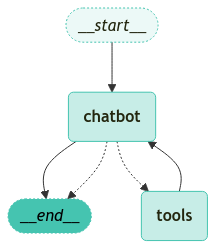

In [2]:
from typing import Annotated, List, Dict
from typing_extensions import TypedDict

from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_teddynote.graphs import visualize_graph
from langchain_teddynote.tools import GoogleNews


########## 1. 상태 정의 ##########
# 상태 정의
class State(TypedDict):
    # 메시지 목록 주석 추가
    messages: Annotated[list, add_messages]
    dummy_data: Annotated[str, "dummy"]


########## 2. 도구 정의 및 바인딩 ##########
# 도구 초기화
# 키워드로 뉴스 검색하는 도구 생성
news_tool = GoogleNews()


@tool
def search_keyword(query: str) -> List[Dict[str, str]]:
    """Look up news by keyword"""
    news_tool = GoogleNews()
    return news_tool.search_by_keyword(query, k=5)


tools = [search_keyword]

# LLM 초기화
llm = ChatOpenAI(model="gpt-4o-mini")

# 도구와 LLM 결합
llm_with_tools = llm.bind_tools(tools)


########## 3. 노드 추가 ##########
# 챗봇 함수 정의
def chatbot(state: State):
    # 메시지 호출 및 반환
    return {
        "messages": [llm_with_tools.invoke(state["messages"])],
        "dummy_data": "[chatbot] 호출, dummy data",  # 테스트를 위하여 더미 데이터를 추가합니다.
    }


# 상태 그래프 생성
graph_builder = StateGraph(State)

# 챗봇 노드 추가
graph_builder.add_node("chatbot", chatbot)


# 도구 노드 생성 및 추가
tool_node = ToolNode(tools=tools)

# 도구 노드 추가
graph_builder.add_node("tools", tool_node)

# 조건부 엣지
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

########## 4. 엣지 추가 ##########

# tools > chatbot
graph_builder.add_edge("tools", "chatbot")

# START > chatbot
graph_builder.add_edge(START, "chatbot")

# chatbot > END
graph_builder.add_edge("chatbot", END)

########## 5. 그래프 컴파일 ##########

# 그래프 빌더 컴파일
graph = graph_builder.compile()

########## 6. 그래프 시각화 ##########
# 그래프 시각화
visualize_graph(graph)

## StateGraph의 `stream` 메서드

`stream` 메서드는 단일 입력에 대한 그래프 단계를 스트리밍하는 기능을 제공합니다.

**매개변수**
- `input` (Union[dict[str, Any], Any]): 그래프에 대한 입력
- `config` (Optional[RunnableConfig]): 실행 구성
- `stream_mode` (Optional[Union[StreamMode, list[StreamMode]]]): 출력 스트리밍 모드
- `output_keys` (Optional[Union[str, Sequence[str]]]): 스트리밍할 키
- `interrupt_before` (Optional[Union[All, Sequence[str]]]): 실행 전에 중단할 노드
- `interrupt_after` (Optional[Union[All, Sequence[str]]]): 실행 후에 중단할 노드
- `debug` (Optional[bool]): 디버그 정보 출력 여부
- `subgraphs` (bool): 하위 그래프 스트리밍 여부

**반환값**
- Iterator[Union[dict[str, Any], Any]]: 그래프의 각 단계 출력. 출력 형태는 `stream_mode`에 따라 다름

**주요 기능**
1. 입력된 설정에 따라 그래프 실행을 스트리밍 방식으로 처리
2. 다양한 스트리밍 모드 지원 (`values`, `updates`, `debug`)
3. 콜백 관리 및 오류 처리
4. 재귀 제한 및 중단 조건 처리

**스트리밍 모드**
- `values`: 각 단계의 현재 상태 값 출력
- `updates`: 각 단계의 상태 업데이트만 출력
- `debug`: 각 단계의 디버그 이벤트 출력

In [5]:
from langchain_core.runnables import RunnableConfig

# 질문
question = "2024년 노벨 문학상 관련 뉴스를 알려주세요."

# 초기 입력 상태를 정의
input = State(dummy_data="테스트 문자열", messages=[("user", question)])

# config 설정
config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정
    tags=["my-tag"],  # Tag
)

`config` 를 설정하고 스트리밍 출력을 진행합니다.

In [7]:
for event in graph.stream(input=input, config=config):
    print("========== event =========")
    print(event)
    print("===================")
    for key, value in event.items():
        print(f"\n[ {key} ]\n")
        # value 에 messages 가 존재하는 경우
        if "messages" in value:
            messages = value["messages"]
            # 가장 최근 메시지 1개만 출력합니다.
            value["messages"][-1].pretty_print()

========== event =========
{'chatbot': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_JanIyFCYOTziMgpd4UAiPtQ5', 'function': {'arguments': '{"query":"2024 Nobel Prize in Literature"}', 'name': 'search_keyword'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 57, 'total_tokens': 77, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-10ab7972-0b2d-4b2b-be1e-6d1e3d71702f-0', tool_calls=[{'name': 'search_keyword', 'args': {'query': '2024 Nobel Prize in Literature'}, 'id': 'call_JanIyFCYOTziMgpd4UAiPtQ5', 'type': 'tool_call'}], usage_metadata={'input_tokens': 57, 'output_tokens': 20, 'total_tokens': 

```bash
{
  "chatbot": {
    "messages": [
      AIMessage(content="",
      additional_kwargs={
        "tool_calls": [
          {
            "id": "call_KTYF4fcRrRW8ANqRhBHi0HNz",
            "function": {
              "arguments": "{"query":"2024 Nobel Prize in Literature"}",
              "name": "search_keyword"
            },
            "type": "function"
          }
        ]
      }
    ],
    "dummy_data": "[chatbot] 호출, dummy data"
  }
}
-------------------
{
  "tools": {
    "messages": [
      ToolMessage(content="[
        {"url": "https://news.google.com/rss/articles/...", "content": "Nobel Prize in Literature 2024 - NobelPrize.org"}, 
        {"url": "https://news.google.com/rss/articles/...", "content": "한강 \\"문학, 생명을 파괴하는 모든 행위에 반대하는 일\\" - Korea.net"},
        {"url": "https://news.google.com/rss/articles/....", "content": "Han Kang’s poetic prose embraces wounds of martial law - 경향신문"}, 
        {"url": "https://news.google.com/rss/articles/...", "content": "한강 \'소년이 온다\' 영문판 \'Human Acts\' 출간 - CulBooks - NYCultureBeat"}, 
        {"url": "https://news.google.com/rss/articles/....", "content": "Han Kang Smiles After Receiving Nobel Prize in Literature Medal and a Significant Cash Prize - 위키트리"}]",
      name="search_keyword",
      id="408f6b1a-bfa6-4676-8f53-e00128a4dc52",
      tool_call_id="call_JanIyFCYOTziMgpd4UAiPtQ5"
      )
    ]
  }
}
```

### `output_keys` 옵션

`output_keys` 옵션은 스트리밍할 키를 지정하는 데 사용됩니다.

list 형식으로 지정할 수 있으며, **channels 에 정의된 키 중 하나** 여야 합니다.

**팁(tip)**

- 매 단계마다 출력되는 State key 가 많은 경우, 일부만 스트리밍하고 싶은 경우에 유용합니다.

In [8]:
# channels 에 정의된 키 목록을 출력합니다.
print(list(graph.channels.keys()))

['messages', 'dummy_data', '__start__', 'chatbot', 'tools', 'branch:__start__:__self__:chatbot', 'branch:__start__:__self__:tools', 'branch:chatbot:__self__:chatbot', 'branch:chatbot:__self__:tools', 'branch:tools:__self__:chatbot', 'branch:tools:__self__:tools', 'start:chatbot', 'branch:chatbot:tools_condition:tools']


In [9]:
# 질문
question = "2024년 노벨 문학상 관련 뉴스를 알려주세요."

# 초기 입력 State 를 정의
input = State(dummy_data="테스트 문자열", messages=[("user", question)])

# config 설정
config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정
    tags=["my-rag"],  # Tag
)

for event in graph.stream(
    input=input,
    config=config,
    output_keys=["dummy_data"],  # messages 를 추가해 보세요!
):
    for key, value in event.items():
        # key 는 노드 이름
        print(f"\n[ {key} ]\n")

        # dummy_data 가 존재하는 경우
        if value:
            # value 는 노드의 출력값
            print(value.keys())
            # dummy_data key 가 존재하는 경우
            if "dummy_data" in value:
                print(value["dummy_data"])


[ chatbot ]

dict_keys(['dummy_data'])
[chatbot] 호출, dummy data

[ tools ]


[ chatbot ]

dict_keys(['dummy_data'])
[chatbot] 호출, dummy data


In [ ]:
# 질문
question = "2024년 노벨 문학상 관련 뉴스를 알려주세요."

# 초기 입력 State 를 정의
input = State(dummy_data="테스트 문자열", messages=[("user", question)])

# config 설정
config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정
    tags=["my-rag"],  # Tag
)

for event in graph.stream(
    input=input,
    config=config,
    output_keys=["messages"],  # messages 만 출력
):
    for key, value in event.items():
        # messages 가 존재하는 경우
        if value and "messages" in value:
            # key 는 노드 이름
            print(f"\n[ {key} ]\n")
            # messages 의 마지막 요소의 content 를 출력합니다.
            print(value["messages"][-1].content)

### `stream_mode` 옵션

`stream_mode` 옵션은 스트리밍 출력 모드를 지정하는 데 사용됩니다.

- `values`: 각 단계의 현재 상태 값 출력 
- `updates`: 각 단계의 상태 업데이트만 출력 (기본값)

#### `stream_mode = "values"`

`values` 모드는 각 단계의 현재 상태 값을 출력합니다.

**참고**

`event.items()`

- `key`: State 의 key 값
- `value`: State 의 key 에 대한하는 value

In [ ]:
# 질문
question = "2024년 노벨 문학상 관련 뉴스를 알려주세요."

# 초기 입력 State 를 정의
input = State(dummy_data="테스트 문자열", messages=[("user", question)])

# config 설정
config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정
    tags=["my-rag"],  # Tag
)

# values 모드로 스트리밍 출력
for event in graph.stream(
    input=input,
    stream_mode="values",  # 기본값
):
    for key, value in event.items():
        # key 는 state 의 key 값
        print(f"\n[ {key} ]\n")
        if key == "messages":
            print(f"메시지 개수: {len(value)}")
            # print(value)
    print("===" * 10, " 단계 ", "===" * 10)

#### `stream_mode = "updates"`

`updates` 모드는 각 단계에 대한 업데이트된 State 만 내보냅니다. 

- 출력은 노드 이름을 key 로, 업데이트된 값을 values 으로 하는 `dictionary` 입니다.

**참고**

`event.items()`

- `key`: 노드(Node) 의 이름
- `value`: 해당 노드(Node) 단계에서의 출력 값(dictionary). 즉, 여러 개의 key-value 쌍을 가진 dictionary 입니다.

In [ ]:
# 질문
question = "2024년 노벨 문학상 관련 뉴스를 알려주세요."

# 초기 입력 State 를 정의
input = State(dummy_data="테스트 문자열", messages=[("user", question)])

# config 설정
config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정
    tags=["my-rag"],  # Tag
)

# updates 모드로 스트리밍 출력
for event in graph.stream(
    input=input,
    stream_mode="updates",  # 기본값
):
    for key, value in event.items():
        # key 는 노드 이름
        print(f"\n[ {key} ]\n")

        # value 는 노드의 출력값
        print(value.keys())

        # value 에는 state 가 dict 형태로 저장(values 의 key 값)
        if "messages" in value:
            print(f"메시지 개수: {len(value['messages'])}")
            # print(value["messages"])
    print("===" * 10, " 단계 ", "===" * 10)

### `interrupt_before` 와 `interrupt_after` 옵션

`interrupt_before` 와 `interrupt_after` 옵션은 스트리밍 중단 시점을 지정하는 데 사용됩니다.

- `interrupt_before`: 지정된 노드 이전에 스트리밍 중단
- `interrupt_after`: 지정된 노드 이후에 스트리밍 중단


In [ ]:
# 질문
question = "2024년 노벨 문학상 관련 뉴스를 알려주세요."

# 초기 입력 State 를 정의
input = State(dummy_data="테스트 문자열", messages=[("user", question)])

# config 설정
config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정
    tags=["my-rag"],  # Tag
)

for event in graph.stream(
    input=input,
    config=config,
    stream_mode="updates",  # 기본값
    interrupt_before=["tools"],  # tools 노드 이전에 스트리밍 중단
):
    for key, value in event.items():
        # key 는 노드 이름
        print(f"\n[{key}]\n")

        # value 는 노드의 출력값
        if isinstance(value, dict):
            print(value.keys())
            if "messages" in value:
                print(value["messages"])

        # value 에는 state 가 dict 형태로 저장(values 의 key 값)
        if "messages" in value:
            print(f"메시지 개수: {len(value['messages'])}")
    print("===" * 10, " 단계 ", "===" * 10)

In [ ]:
# 질문
question = "2024년 노벨 문학상 관련 뉴스를 알려주세요."

# 초기 입력 State 를 정의
input = State(dummy_data="테스트 문자열", messages=[("user", question)])

# config 설정
config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정
    tags=["my-rag"],  # Tag
)

for event in graph.stream(
    input=input,
    config=config,
    stream_mode="updates",
    interrupt_after=["tools"],  # tools 실행 후 interrupt
):
    for value in event.values():
        # key 는 노드 이름
        print(f"\n[{key}]\n")

        if isinstance(value, dict):
            # value 는 노드의 출력값
            print(value.keys())
            if "messages" in value:
                print(value["messages"])

        # value 에는 state 가 dict 형태로 저장(values 의 key 값)
        if "messages" in value:
            print(f"메시지 개수: {len(value['messages'])}")